In [22]:
import numpy as np
import torch

## Wyzwanie
Perceptron dla obecnych sieci neuronowych jest jak Australopitek dla Homo sapiens - możemy się śmiać, że sieć kiedyś była taka prymitywna, ale bez zrozumienia niej - nie zrozumiemy całego skomplikowania nowoczesnych architektur. Twoim zadaniem będzie implementacja perceptronu, a także jego nauka od zera. Wyniki zweryfikujesz implementując na końcu taką samą sieć w [Pytorchu](https://docs.pytorch.org/docs/stable/index.html).

## Jak zrobić zadanie
0. Dane są te same co w poprzednim zadaniu - [Bank Marketing](https://archive.ics.uci.edu/dataset/222/bank+marketing)
1. Wykorzystaj wiedzę z poprzedniego notebooka (jak i kod, jeśli się da) do przygotowania danych. Pamiętaj o podziale na zbiory train, val i test. Przeskaluj dane używając StandardScaler lub innych, oczywiście unikając wycieku danych.
2. Możecie ograniczyć się do dwóch cech wejściowych - wybranych wedle uznania - do celów zadania (np. dwie cechy łatwiej jest zwizualizować)
3. Niżej są podane instrukcje (symbol ⚡ oznacza, że coś trzeba zaimplementować) - najlepiej rób je sekwencyjnie.

przydatne materiały:
* [deep_learning_60min_blitz](https://docs.pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html),
* [zrozumienie under/overfitting](https://mlu-explain.github.io/bias-variance/),
* [SUPER tutorial(e)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html),
* [Mathematics of neural networks in machine learning](https://en.wikipedia.org/wiki/Mathematics_of_neural_networks_in_machine_learning),
* [Pozycja 53 -> rozdziały 2 (fenomenalny),11](https://docs.google.com/spreadsheets/d/1UnjOh5TYgNiFBw9jsM6mJrp68uEdzeW3iIi6Ew0xfgQ/edit?gid=0#gid=0),
* [Optymizatory & uczenie paczkami](https://arxiv.org/pdf/1609.04747)


### Problemy w uczeniu maszynowym

Przypomnijmy sobie jeszcze czym się różni zadanie **klasyfikacji** od **regresji**. Jak już zapewne wiesz, nasze dane można podzielić na zbiór cech (X) oraz na zbiór zmiennych docelowych (y). Ten drugi może kodować informacje o tym, jaka jest klasa przynależności (np. *chory ∈ {true, false}*, *kolor ∈ {zielony, niebieski, czerwony}*), lub jaka jest wartość pewnej cechy (np. *temperatura ∈ ℜ*, *punkty z egzaminu* ∈ 𝒵). W zadaniu klasyfikacji mamy do czynienia z kategoriami, które są dyskretne, a w zadaniu regresji zmienne docelowe są zwykle ciągłe. Dlaczego to istotne? W trakcie pracy nad notebookiem pewnie zdasz sobie sprawę, że nie można do problemu klasyfikacji użyć straty najmniejszych kwadratów - co byłoby odpowiednie w problemie regresji.

## 1. Perceptron*
Wejdziemy w trochę matematyki (serio, matma jest niezbędna jeśli chcesz być Pro AI engineer'em). Najprostszy perceptron opisany jest wzorem

$$A = σ(𝑤^TX + b) = σ(Z) = (a_1, ..., a_{m-1})$$
gdzie


*   σ to funkcja aktywacji
*   $X$ to macierz cech, wymiaru $k \times m$ ($=$ liczba cech $\times$ liczba próbek)
*   𝑤 to macierz wag z $k$ wartościami (wyuczalne parametry)
*   b to skalar, zwany *biasem* (wyuczalny parametr)
*   $A$ to wyjściowy wektor o długości $m$

Popularne funkcje aktywacji:
- Relu: $f(Z) = max(Z, 0)$
- Sigmoid: $f(Z) = \frac{1}{1 + e^{-Z}}$

Jednak w tym zadaniu poprawna będzie tylko jedna - musisz sam(a) wybrać która to będzie i dlaczego. (Hint: zastanów się, *co oznacza wyjście sieci*, i dlaczego ta "niepoprawna" funkcja aktywacji będzie psuła sieć)

*W rzeczywistości nie będzie to [stricte perceptron](https://pl.wikipedia.org/wiki/Perceptron), ponieważ nie będziemy implementować skokowej funkcji straty.

### ⚡ Zaimplementuj tutaj perceptron

In [23]:
class Perceptron:

  def __init__(self):
    pass

  def forward(self, X: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    pass

### Przejście w przód i w tył

Następnym zadaniem jest wyuczenie naszych macierzy. Prawdopodobnie twoje wartości są losowe (mam nadzieję, że macierz nie jest wypełniona zerami), przez co i sieć daje losowe wyniki. To, co możemy wydzielić jako atomową operację w procesie uczenia sieci składa się z kroków:
1. Forward propagation (przejście w przód) - wymnożenie wejściowych cech przez wagi sieci
2. Loss (obliczanie straty) - obliczamy jaki jest błąd popełniany przez sieć
3. Backward propagation (przejście w tył) - propagacja gradientu i **aktualizacja** wag sieci

Proces uczenia zachodzi w N epokach.

Pytanie filozoficzne: czy strata może być równa zero? czy możemy wyczyć idealną sieć? Jak sądzisz, w jakich warunkach tak może być? (warto na takie przemyślenie poświęcić >=30 sekund).

Matematycznie ma to taką postać:
* Fp: $A = σ(𝑤^TX + b) = σ(Z)$ (to było już)
* Loss: L = $\frac{1}{M} g(A, Gt)$, gdzie $Gt$ to prawdziwe, poprawne wartości, a $g$ to odpowiednia dla problemu funkcja straty. Dzielimy przez liczbę próbek, bo chcemy uzyskać średnią wartość błędu,
* Bp: niestety nie zachodzi w jednym kroku. Rozpiszmy to

$$L = \frac{1}{M} g(A, Gt)$$  -> mamy nasz wyliczony loss (musimy mieć wartość skalarną, dlatego uśredniamy startę)
$$\frac{∂L}{∂𝑤} = ? $$ -> to chcemy wyliczyć (zaraz, zaraz powiemy po co)
$$ \frac{∂L}{∂𝑤} = \frac{∂L}{∂A} \frac{∂A}{∂Z} \frac{∂Z}{∂w}$$ -> to wynika z [twierdzenia łańcuchowego](https://en.wikipedia.org/wiki/Chain_rule)

Jaki mamy deal z tego? Otóż będziemy obliczać pochodne zmiany funkcji starty względem parametrów sieci tak, by je dostosowywać w kierunku zmniejszenia się tej straty (spadek wzdłuż gradientu [link text](https://en.wikipedia.org/wiki/Gradient_descent)). Aktualizacja wag sieci, w epoce n, ma postać:

$$𝑤^{n + 1} = 𝑤^{n} - \alpha \frac{∂L}{∂𝑤}$$

gdzie $\alpha$ jest hiperparameterem (czyli taką wartością, która jest ustalana z góry, przed uruchomieniem treningu), zwykle o wartościach $0.01$, czy $0.001$.
 Decyduje ona o szybkości treningu.

 Twoim zadaniem jest teraz ⚡ implementacja klasy do trenowania, dla której docelowo chcemy tylko wywołać funkcję *train*, a w środku ma zachodzić cała magia. Funkcja *predict* ma służyć do predykcji kategorii dla próbek testowych.

In [24]:
class Trainer:

  def __init__(self, perceptron: Perceptron, n_epochs: int):
    self.perceptron = perceptron
    self.n_epochs = n_epochs

  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    return None

  def backward(self, X: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    return None

  def update_weights(self): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    return None

  def train(self, X: np.ndarray, y: np.ndarray): # wykonuje trenowanie w N epokach
    return None

  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    return None

## HINTS
Hint1: na kartce rozpisz sobie krok po kroku przejście w przód. Najlepiej użyj tej samej konwencji nazewniczej zmiennych, lub zdefiniuj zmienne pomocniczne. Rozwiń jaki będzie konkretny wzór na pochodne: $\frac{∂L}{∂A}$, $\frac{∂A}{∂z}$ i  $\frac{∂z}{∂w}$. Jak już przez to przebrniesz, to przepisanie tego do Pythona powinno być bezbolesne i skuteczne.

Hint2: Funkcje straty, które powinieneś/powinnaś rozważać to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) lub [BCE](https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/). Jeśli rozpisanie gradientu jest dla ciebie nie do przejścia, to posłuż się "gotowcem", ale nadal spróbuj samodzielnie przepisać na kod.

Hint3: do mnożenia macierzy w numpy używamy ```np.dot``` lub ```@```.

Hint4: początkowe wartości macierzy $𝑤$ mogą być zaincjalizowane losowymi wartościami z niewielkiego zakresu (np. $[-0.01, 0.01]$)

Hint5: wartości wejściowe powinny być ustandaryzowane (dla poprawy jakości spadku wzdłuż gradientu)

### Uczenie paczkami
Być może już zauważyłeś/łaś, że wymnażanie wielkiej macierzy $X$ w pojedynczym kroku jest problematyczne - jeśli nie w tym eksperymencie, to w następnym. Istnieją różne strategie do aktualizacji parametrów:
* batch gradient descent - aktualizacja parametrów odbywa się po przejściu wszystkich próbek przez sieć, a gradient jest uśredniany (to, co pewnie masz teraz)
* stochastic gradient descent - aktualizacja parametrów następuje po każdej pojedynczej próbce (podejście na drugim końcu spektrum)
* mini-batch stochastic gradient descent - podział wszystkich próbek na paczki o wielkości $M$, i aktualizacja gradientu po każdej paczce (podejście "po środku" dwóch poprzednich)

Zastanów się, które podejście jest odpowiednie i w funkcji *train* ⚡ doimplementuj odpowiedni podział (lub nie?) macierzy danych $X$.

Nic nie stoi na przeszkodzie, by udokumentować zachowanie sieci dla każdej strategii (możesz to zawrzeć w dalszej sekcji eksperymentów).


### Śledzenie przebiegu uczenia

W praktyce, sam spadek wzdłuż gradientu nie gwarantuje, że dostaniemy optymalne wagi sieci. W celu weryfikacji, czy nie doszło do **przeuczenia**, twoim ⚡ kolejnym krokiem będzie dodanie do klasy *Trainer* funkcji, które zapiszą, na końcu każdej epoki

 (a) istotne metryki w kontekście zadania,

(b) wartość straty

zarówno dla zbioru treningowego, jak i walidacyjnego - najlepiej w postaci wykresu. Na ich podstawie zdiagnozuj, czy model podlega **niedouczeniu / underfitting**, **przeuczeniu / overfitting**, a może jest względnie "dobry".  

### ⭐ Ekstra zadanie - optymizator
Spadek wzdłuż gradientu zawsze bierze pod uwagę tylko aktualne wartości gradientów, przez co może być podatny na gwałtowne zmiany. W celu wydajniejszego trenowania stosuje się [optymizatory](https://arxiv.org/pdf/1609.04747) typu *Momentum* czy *Adagrad* (choć w praktyce zwykle *Adam*). Zaimplementuj wybrany optimzator i porównaj, jak uczy się sieć z i bez, oraz jak zmieniają się wartości wag (np. możesz logować bezwzględną, uśrednioną wartość zmian wag).

### ⚡ Eksperymenty
Zbadaj skuteczność sieci oraz oceń, czy dobrze się generalizuje na podstawie krzywych uczenia. Dokładniej, zbadaj co najmniej **3 wartości współczynnika uczenia** i **3 wartości liczby epok**. Zapisz swoje obserwacje. Nie przejmuj się, jeśli po nieudanych próbach twoja sieć nie chce się uczyć - jeśli czujesz, że wiesz w czym leży błąd, to zapisz te obserwacje.

## 2. Implementacja sieci w pytorchu
Następnie ⚡ zaimplementujesz perceptron korzystając z biblioteki pytorch w celu weryfikacji wyników.

### Tensory
Są to struktury danych zbliżone do macierzy **np.array**, tyle, że mogą być przenoszone na karty graficzne, które są niezbędne do wyuczenia głębokich sieci. W następującej części zadania będziesz musiał(a) opanować pracę z tensorami i ich zamianę z i do tablicy NumPy.

In [25]:
data_list = [[2, 5], [3, 6],[4, 7]]
numpy_array = np.array(data_list) # tablica numpy utworzona z listy
data_tensor = torch.from_numpy(numpy_array) # tensor utworzony z tablicy numpy
print(data_tensor.shape) # kształt tensora
data_tensor

torch.Size([3, 2])


tensor([[2, 5],
        [3, 6],
        [4, 7]])

### Perceptron w torchu
Z wykorzystaniem biblioteki [torch.nn](https://docs.pytorch.org/docs/stable/nn.html) ⚡ zaimplementuj jednowarstwową sieć neuronową wraz z jej trenowaniem, z która porównasz swoją sieć zbudowaną w numpy. Przydatny może być tutorial [pytorch-nn](https://docs.pytorch.org/tutorials/beginner/pytorch_with_examples.html#learning-pytorch-with-examples). ⚡ Powtórz te same eksperymenty, które wykonane zostały dla twojego Perceptronu, oraz porównaj ze sobą wyniki. Zastanów się, skąd mogą wynikać różnice oraz dlaczego ostatecznie nie chcelibyśmy implementować sieci neuronowych w numpy 😅.


---


*Uwaga*: jeśli czujesz, że jest to dla ciebie zbyt proste, to skontruuj klasę wielowarstwowej sieci neuronowej do "prawdziwego" rozwiązania problemu (spróbuj wtedy wykorzystać (prawie) wszystkie kolumny).

*Uwaga do uwagi*: jeśli czujesz, że to nadal za mało, to przepisz sieć do frameworka [lightning](https://lightning.ai/docs/pytorch/stable/). Dodaj do tego logowanie w tensorboard.

### Taki smaczek

Perceptron wg. Nano Banana. Co poszło źle?


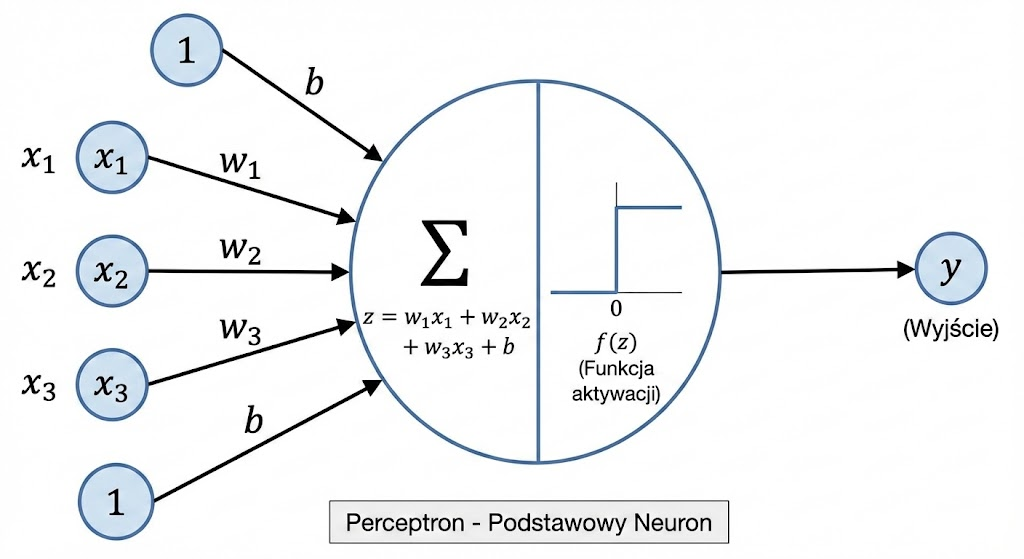

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc

In [82]:
from pathlib import Path
base_path = Path('/content/drive/MyDrive/wdrozenie_ml')

df = pd.read_csv(base_path / 'bank_dataframe.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,age,job,marital,default,balance,housing,loan,month,campaign,y,contacted_before
0,58,management,married,0,2143,1,0,may,1,0,0
1,44,technician,single,0,29,1,0,may,1,0,0
2,33,entrepreneur,married,0,2,1,1,may,1,0,0
3,47,blue-collar,married,0,1506,1,0,may,1,0,0
4,33,unknown,single,0,1,0,0,may,1,0,0


# Dla usprawnienia ograniczam dataframe do mniejszej ilości cech
Ze względu na wpływ housing, age oraz contacted_before, zostawiam te kolumny

In [83]:
to_drop = ['job', 'marital', 'default', 'balance', 'loan', 'month', 'campaign']

df.drop(to_drop, axis=1, inplace=True)
df.head()

,age,housing,y,contacted_before
0,58,1,0,0
1,44,1,0,0
2,33,1,0,0
3,47,1,0,0
4,33,0,0,0


In [84]:
from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Skalowanie danych (tak jak w poprzednim zadaniu)

In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
  transformers=[
    ('num', StandardScaler(), ['age']),
    ('bin', 'passthrough', ['housing', 'contacted_before']),
  ]
)

In [86]:
preprocessor.fit(X_train)

X_train_scaled = preprocessor.transform(X_train)
X_val_scaled   = preprocessor.transform(X_val)
X_test_scaled  = preprocessor.transform(X_test)

# Implementacja perceptronu

Funkcją aktywacji będzie sigmoid, ponieważ liczymy tutaj na klasyfikację  binarną, a daje on wyniki z przedziału [0, 1]
Idąc za tym, jako funkcji straty użyję BCE

In [90]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# def BCE(y_pred, y_true, X): # później nie używam tej funkcji, a tylko jej fragmentów
#
#   y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7) # np.clip w celu uniknięcia log(0)
#
#   loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
#   error = y_pred - y_true
#   grad_w = np.dot(X.T, error) / X.shape[0]
#   grad_b = np.sum(error) / X.shape[0]
#   return loss, grad_w, grad_b

In [88]:
class Perceptron:

  def __init__(self, n_features, eta=0.01):
    self.eta = eta
    self.w_ = np.zeros(n_features)
    self.b_ = 0.0

  def forward(self, X: np.ndarray):
    z = np.dot(X, self.w_) + self.b_
    return sigmoid(z)

In [91]:
class Trainer:

  def __init__(self, perceptron: Perceptron, n_epochs: int):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.loss_history = []

  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    y_pred = np.clip(A, 1e-7, 1 - 1e-7) # np.clip w celu uniknięcia log(0)
    y_true = y
    return -np.mean(y_pred * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

  def backward(self, X: np.ndarray, y: np.ndarray):
    error = self.perceptron.forward(X) - y
    grad_w = np.dot(X.T, error) / X.shape[0]
    grad_b = np.sum(error) / X.shape[0]
    return grad_w, grad_b

  def update_weights(self, grad_w, grad_b):
    self.perceptron.w_ -= self.perceptron.eta * grad_w
    self.perceptron.b_ -= self.perceptron.eta * grad_b

  def train(self, X: np.ndarray, y: np.ndarray): # wykonuje trenowanie w N epokach
    for epoch in range(self.n_epochs):
      # forward
      A = self.perceptron.forward(X)

      # loss
      loss_val = self.loss(A, y)
      if epoch%100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss_val}')
      self.loss_history.append(loss_val)

      # backward
      grad_w, grad_b = self.backward(X, y)

      # update_weights
      self.update_weights(grad_w, grad_b)

  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    pred = self.perceptron.forward(X)
    return (pred >= 0.5).astype(int)


Zastosowałem strategię batch gradient descent do aktualizacji parametrów

# Proces treningowy

In [92]:
n_features = X_train_scaled.shape[1]
perceptron = Perceptron(n_features=n_features, eta=0.1)

In [93]:
trainer = Trainer(perceptron=perceptron, n_epochs=1000)
trainer.train(X_train_scaled, y_train)

Epoch: 0, Loss: 0.9588787876046424
Epoch: 100, Loss: 0.4331131926280688
Epoch: 200, Loss: 0.3747643463024635
Epoch: 300, Loss: 0.3601247542905994
Epoch: 400, Loss: 0.3548891593027736
Epoch: 500, Loss: 0.35201479562819576
Epoch: 600, Loss: 0.3498029831962759
Epoch: 700, Loss: 0.3478617644137087
Epoch: 800, Loss: 0.3461183292909896
Epoch: 900, Loss: 0.34456558286137723


Eksperymentowanie

In [94]:
eta_values = [0.001, 0.01, 0.1]
n_epoch_values = [100, 500, 1000]

best_loss = float('inf')
best_params = None

results = {}

for eta in eta_values:
  for n_epochs in n_epoch_values:
    perceptron = Perceptron(n_features=n_features, eta=eta)
    trainer = Trainer(perceptron=perceptron, n_epochs=n_epochs)
    trainer.train(X_train_scaled, y_train)
    loss = trainer.loss_history[-1]
    if loss < best_loss:
      best_loss = loss
      best_params = (eta, n_epochs)
    key = f"eta={eta}, n_epochs={n_epochs}"
    results[key] = {
        "loss_history": trainer.loss_history,
        "train_acc": (trainer.predict(X_train_scaled) == y_train).mean(),
        "val_acc": (trainer.predict(X_val_scaled) == y_val).mean()
    }


print("Najlepszy loss: ", best_loss)
print("Najlepsze parametry: ", best_params)

Epoch: 0, Loss: 0.9588787876046424
Epoch: 0, Loss: 0.9588787876046424
Epoch: 100, Loss: 0.9400429671955058
Epoch: 200, Loss: 0.9221072101940354
Epoch: 300, Loss: 0.9050093359625393
Epoch: 400, Loss: 0.8886927028278113
Epoch: 0, Loss: 0.9588787876046424
Epoch: 100, Loss: 0.9400429671955058
Epoch: 200, Loss: 0.9221072101940354
Epoch: 300, Loss: 0.9050093359625393
Epoch: 400, Loss: 0.8886927028278113
Epoch: 500, Loss: 0.8731057085466322
Epoch: 600, Loss: 0.8582013074944663
Epoch: 700, Loss: 0.8439365558166022
Epoch: 800, Loss: 0.8302721910521541
Epoch: 900, Loss: 0.8171722492162815
Epoch: 0, Loss: 0.9588787876046424
Epoch: 0, Loss: 0.9588787876046424
Epoch: 100, Loss: 0.8044127846797524
Epoch: 200, Loss: 0.7022218909728315
Epoch: 300, Loss: 0.630446451980298
Epoch: 400, Loss: 0.5779131922246348
Epoch: 0, Loss: 0.9588787876046424
Epoch: 100, Loss: 0.8044127846797524
Epoch: 200, Loss: 0.7022218909728315
Epoch: 300, Loss: 0.630446451980298
Epoch: 400, Loss: 0.5779131922246348
Epoch: 500, Los

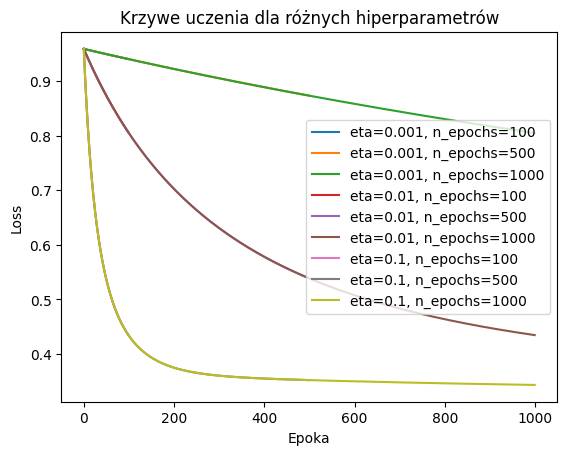

In [95]:
for key, res in results.items():
    plt.plot(res["loss_history"], label=key)

plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Krzywe uczenia dla różnych hiperparametrów")
plt.legend()
plt.show()

Na wykresie widzimy różnicę między różnymi wyborami parametru eta, 0.1 został wybrany dla najlepszej wartości loss.

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)

y_train_np = y_train.to_numpy().reshape(-1, 1)
y_val_np   = y_val.to_numpy().reshape(-1, 1)

y_train_t = torch.tensor(y_train_np, dtype=torch.float32)
y_val_t   = torch.tensor(y_val_np, dtype=torch.float32)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)

In [117]:
class TorchPerceptron(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

n_features = X_train_t.shape[1]
model = TorchPerceptron(n_features)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

Uczenie perceptronu

In [118]:
n_epochs = 100
loss_history = []

for epoch in range(n_epochs):
    model.train()

    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")

Epoch 10/100, Loss: 0.5264
Epoch 20/100, Loss: 0.4574
Epoch 30/100, Loss: 0.4196
Epoch 40/100, Loss: 0.3975
Epoch 50/100, Loss: 0.3837
Epoch 60/100, Loss: 0.3747
Epoch 70/100, Loss: 0.3686
Epoch 80/100, Loss: 0.3642
Epoch 90/100, Loss: 0.3610
Epoch 100/100, Loss: 0.3586


Validation accuracy: 0.8789442777633667


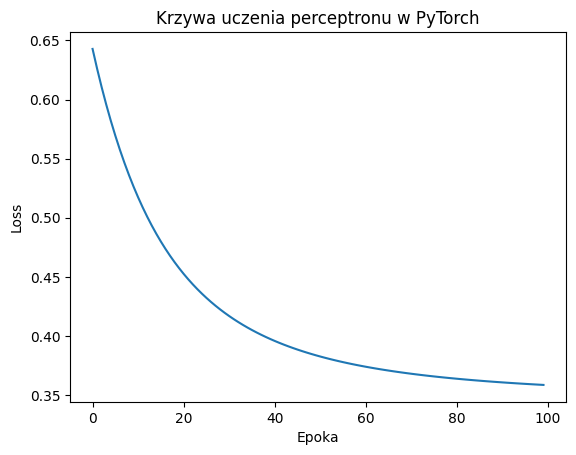

In [119]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_t)
    y_val_pred_class = (y_val_pred >= 0.5).float()
    acc = (y_val_pred_class == y_val_t).float().mean()
    print("Validation accuracy:", acc.item())

plt.plot(loss_history)
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Krzywa uczenia perceptronu w PyTorch")
plt.show()

In [123]:
y_val_pred_class = trainer.predict(X_val_scaled)
acc = np.mean(y_val_pred_class == y_val)
print("Validation accuracy:", acc)

Validation accuracy: 0.8789442642288411


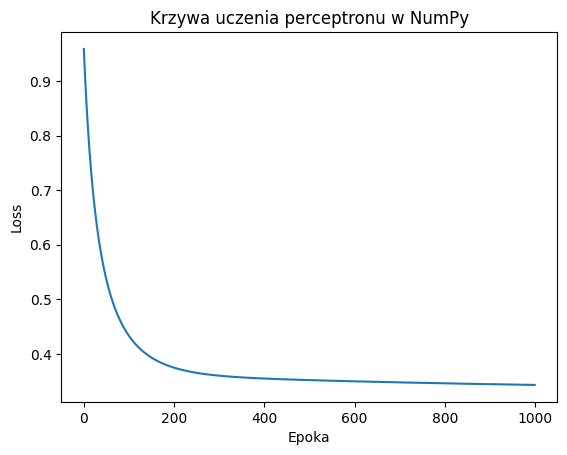

In [124]:
plt.plot(trainer.loss_history)
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.title("Krzywa uczenia perceptronu w NumPy")
plt.show()

Dokładność mojego perceptronu prezentuje się dobrze, ale to najprawdopodobniej dlatego, że większość odpowiedzi i tak wynosi 0.

Na wykresach widzimy procesy uczenia obu modeli.